In [530]:
import seaborn as sns
import sdeint
import matplotlib.pyplot as plt
import pandas as pd
import sympy as smp
import random
import numpy as np
from sklearn.metrics import DistanceMetric
import pycatch22 as catch22
from sympy import real_roots
from sklearn.manifold import MDS
import scipy
from sklearn.pipeline import Pipeline
import statistics
from scipy.optimize import minimize, optimize
from sklearn.base import BaseEstimator, TransformerMixin
import scipy.cluster.hierarchy as sch
from scipy.optimize import fsolve
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA, FactorAnalysis
from scipy.spatial.distance import pdist, squareform, cdist
from time import perf_counter

Streamlined version of part 2 for generation of figures as well as evaluation.

In [3]:
np.random.seed(42)

In [4]:
def gen_bistable(eta, mu, N):
    dt = 0.01
    length = ((N+500)*dt)
    tspan = np.arange(0, length, dt)
    def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
    ic = np.array([np.random.uniform()])
    gw = lambda y, t: eta * np.identity(ic.shape[0])
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    return sol[500:] # exclude 500 samples for transients

In [5]:
def gen_hopf(eta, mu, N):
    dt = 0.01
    length = ((N+500)*dt)
    tspan = np.arange(0, length, dt)
    def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
    ic = np.array(np.random.uniform(size=2))
    gw = lambda y, t: eta * np.identity(ic.shape[0])
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    return sol[500:]

In [6]:
def gen_hookes(eta, mu, N):
    dt = 0.01
    length = ((N+500)*dt)
    tspan = np.arange(0, length, dt)
    def f(state, t):
            x = state[0]
            dxdt = mu *x
            return dxdt
    ic = np.array([np.random.uniform(low=0, high=0.2)])
    gw = lambda y, t: eta * np.identity(ic.shape[0])
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array([ic]), tspan)
    return sol[500:]

In [7]:
def sample_fixedpt(num_samples):
    samples_per_system = int(num_samples/3)

    # bistable
    eta_val_bistable = list()
    mu_val_bistable = list()
    n_val_bistable = list()
    lengths_store = list()
    sols_list = list()
    count = 0
    while count < samples_per_system:
        eta = np.random.uniform(low=0, high=1)
        mu = np.random.uniform(low=-5, high=5)
        n = np.random.uniform(low=50, high=5000)

        sol = gen_bistable(eta, mu, n)
        X = smp.Symbol('x', real=True)
        eq = mu + X - X**3
        roots = [j.n(6) for j in real_roots(eq, X)]
        max_root = np.max(roots)
        min_root = np.min(roots)
        max_actual = np.max(sol)
        min_actual = np.min(sol)
        if (len(roots) > 1) & (max_actual >= max_root) & (min_actual <= min_root):
            # switching, do not append
            continue
        else:
            count += 1
            sols_list.append(sol)
            eta_val_bistable.append(eta)
            mu_val_bistable.append(mu)
            n_val_bistable.append(n)
            lengths_store.append(len(sol)) # store length of time series after burn in

    ts_bistable = sols_list
    features_bistable = np.array([catch22.catch22_all(ts_bistable[i][:,0])['values'] for i in range(len(sols_list))])
    df_bistable = pd.DataFrame(features_bistable)
    df_bistable['N'] = lengths_store
    df_bistable['mu'] = mu_val_bistable
    df_bistable['eta'] = eta_val_bistable
    df_bistable['regime'] = 'FixedPoint'
    df_bistable['system'] = 'Bistable'

    # hopf system

    eta_val_hopf = np.random.uniform(0, 1, samples_per_system)
    mu_val_hopf = np.random.uniform(-5, -0.01, samples_per_system)
    N_val_hopf = np.random.uniform(50, 5000, samples_per_system)
    lengths_store = list()
    sols_list = list()
    for i in range(samples_per_system):
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        N = N_val_hopf[i]
        sol = gen_bistable(eta, mu, N)
        lengths_store.append(len(sol)) # store length of time series after burn in
        sols_list.append(sol)

    features_hopf = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    ts_hopf = sols_list # return list of 2 dim. time series
    df_hopf = pd.DataFrame(features_hopf)
    df_hopf['N'] = lengths_store
    df_hopf['mu'] = mu_val_hopf
    df_hopf['eta'] = eta_val_hopf
    df_hopf['regime'] = 'FixedPoint'
    df_hopf['system'] = 'Hopf'

    # hooke's system

    n_val_hookes = np.random.uniform(low=50, high=5000, size=samples_per_system)
    eta_val_hookes = np.random.uniform(low=0, high=1, size=samples_per_system)
    mu_val_hookes = np.random.uniform(low=-5, high=-0.01, size=samples_per_system)
    sols_list = list()
    lengths_store = list()
    for i in range(samples_per_system):
        mu = mu_val_hookes[i]
        eta = eta_val_hookes[i]
        N = n_val_hookes[i]
        sol = gen_hookes(eta, mu, N)
        lengths_store.append(len(sol)) # store length of time series after burn in
        sols_list.append(sol)
    features_hookes = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    ts_hookes = sols_list
    df_hookes = pd.DataFrame(features_hookes)
    df_hookes['N'] = lengths_store
    df_hookes['mu'] = mu_val_hookes
    df_hookes['eta'] = eta_val_hookes
    df_hookes['regime'] = 'FixedPoint'
    df_hookes['system'] = 'Hookes'

    ts = ts_bistable + ts_hopf + ts_hookes
    df = pd.concat([df_bistable, df_hopf, df_hookes], ignore_index=True)

    return ts, df

In [8]:
def sample_switching(num_samples):
    eta_val_bistable = list()
    mu_val_bistable = list()
    sols_list = list()
    lengths_store = list()
    count = 0 
    while count < num_samples:
        mu = np.random.uniform(low=-0.38487849, high=0.38487849)
        eta = np.random.uniform(0.001, 1)
        n = np.random.uniform(50, 5000)
        sol = gen_bistable(eta, mu, n)
        X = smp.Symbol('x', real=True)
        eq = mu + X - X**3
        roots = [j.n(6) for j in real_roots(eq, X)]
        max_root = np.max(roots)
        min_root = np.min(roots)
        max_actual = np.max(sol)
        min_actual = np.min(sol)
        # check for switching condition
        if (max_actual >= max_root) & (min_actual <= min_root):
            eta_val_bistable.append(eta)
            mu_val_bistable.append(mu)
            sols_list.append(sol)
            lengths_store.append(len(sol)) # store length of time series after burn in
            count += 1
    ts = sols_list 
    features_bistable = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features_bistable)
    df['N'] = lengths_store
    df['mu'] = mu_val_bistable
    df['eta'] = eta_val_bistable
    df['regime'] = 'Switching'
    df['system'] = 'Bistable'
    
    return ts, df

In [9]:
def sample_limitCycle(num_samples):

    # hopf system
    eta_val_hopf = np.random.uniform(0, 1, num_samples)
    mu_val_hopf = np.random.uniform(0, 5, num_samples)
    N_val_hopf = np.random.uniform(50, 5000, num_samples)
    lengths_store = list()
    sols_list = list()
    for i in range(num_samples):
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        N = N_val_hopf[i]
        sol = gen_hopf(eta, mu, N)
        lengths_store.append(len(sol)) # store length of time series after burn in
        sols_list.append(sol)

    features_hopf = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    ts = sols_list # return list of 2 dim. time series
    df = pd.DataFrame(features_hopf)
    df['N'] = lengths_store
    df['mu'] = mu_val_hopf
    df['eta'] = eta_val_hopf
    df['regime'] = 'LimitCycle'
    df['system'] = 'Hopf'

    return ts, df

In [10]:
# 54 min
ts1, df1 = sample_fixedpt(5000)
ts2, df2 = sample_switching(5000)
ts3, df3 = sample_limitCycle(5000)

Examine the distribution of parameters for switching instances, given their acceptance criteria.

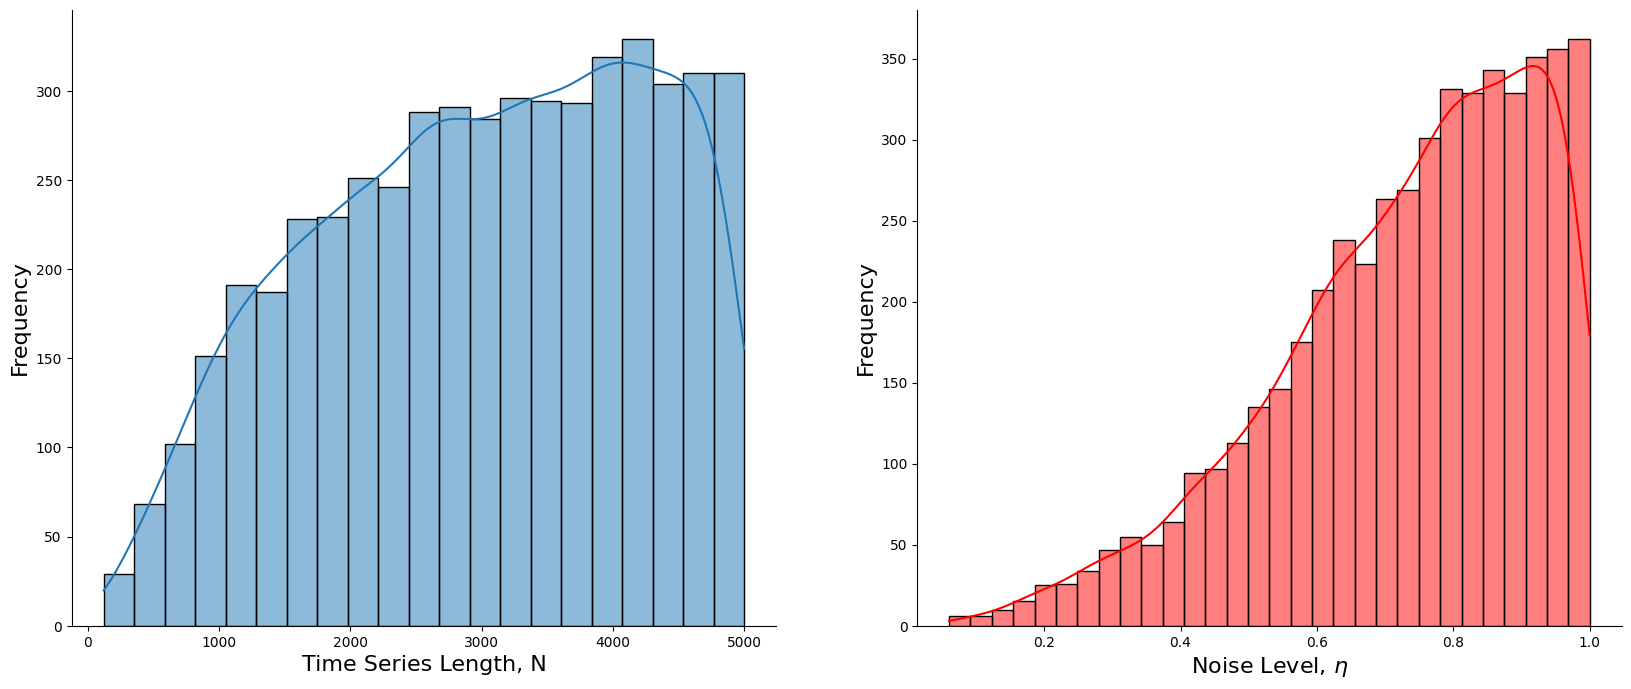

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(df2['N'], kde=True, ax=ax[0])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_xlabel('Time Series Length, N', fontsize=16)
ax[0].set_ylabel('Frequency', fontsize=16)


sns.histplot(df2['eta'], kde=True, ax=ax[1], color='red')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xlabel('Noise Level, $\eta$', fontsize=16)
ax[1].set_ylabel('Frequency', fontsize=16)
plt.show()

In [12]:
x = pd.concat([df1, df2, df3], ignore_index=True)
y = x['regime']

In [13]:
class SigmoidTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, a=1):
        self.a = a # slope 

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return scipy.special.expit(self.a*X)

In [14]:
pipe = Pipeline([
    ('robust', RobustScaler()),
    ('sigmoid', SigmoidTransformer()),
    ('minmax', MinMaxScaler())
])

In [15]:
fit = pipe.fit(x.iloc[:, :22])
xhat = fit.transform(x.iloc[:, :22])

In [16]:
pca = PCA(n_components=2).fit(xhat)
pca_train = pca.transform(xhat)

In [17]:
pca_df = pd.DataFrame(pca_train, columns=['PC1', 'PC2'])
pca_df['eta'] = x['eta']
pca_df['regime'] = y
pca_df['system'] = x['system']

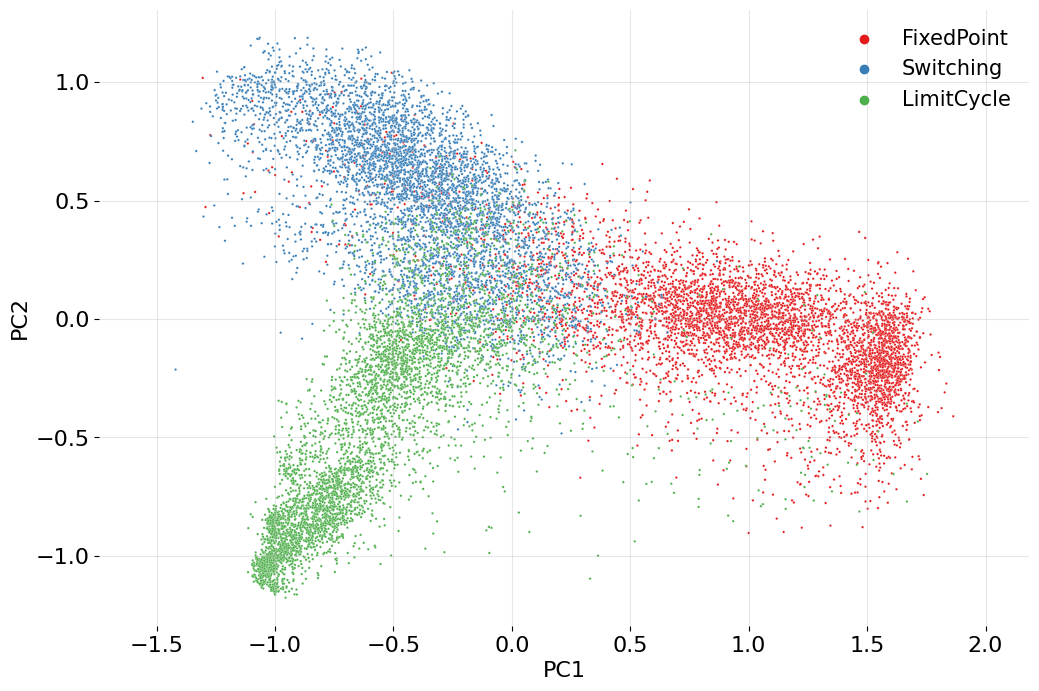

In [18]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x='PC1', y='PC2', hue='regime', data=pca_df, s=3, palette='Set1')
plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(alpha=0.3)
plt.axis('equal')
plt.legend(frameon=False, fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#plt.savefig('instance_space_toy.svg', dpi=300)

kernel density estimate for contour plot (using Gaussian kernel)

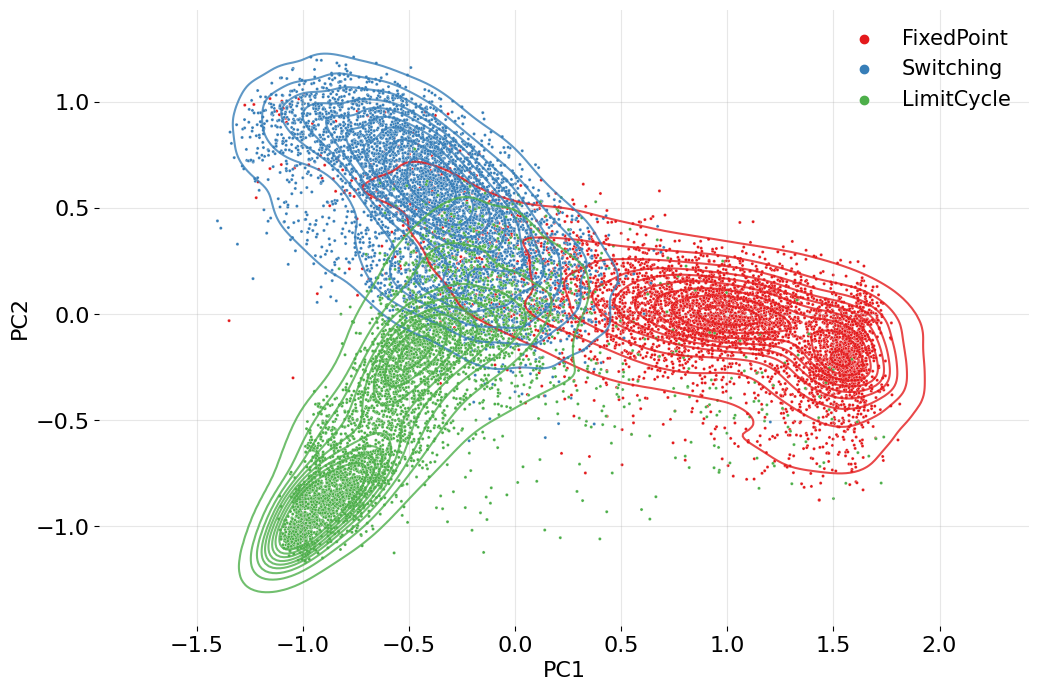

In [17]:
plt.figure(figsize=(12,8))
sns.kdeplot(x='PC1', y='PC2', hue='regime', data=pca_df, fill=False, alpha=0.8, palette='Set1')
ax = sns.scatterplot(x='PC1', y='PC2', hue='regime', data=pca_df, s=5, palette='Set1')
plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(alpha=0.3)
plt.axis('equal')
plt.legend(frameon=False, fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.savefig('instance_space_toy_kde.svg', dpi=300)


### Pairwise distance calculation

Compute intra- and inter- class distances in 2D space as an indication of feature space performance

In [19]:
grouped = pca_df.groupby('regime')

In [20]:
grouped = pca_df.groupby('regime')
intra_class_distances = list()
for name, group in grouped:
    # compute intra-class distances
    group_data = group.drop(['regime', 'eta', 'system'], axis=1)
    intra_class_dist = pdist(group_data.values, metric='euclidean')
    intra_class_distances.append(intra_class_dist)
    print(name, intra_class_dist.mean())

inter_class_distances = list()
for name1, group1 in grouped:
    for name2, group2 in grouped:
        if name1 != name2:
            group1_data = group1.drop(['regime', 'eta', 'system'], axis=1)
            group2_data = group2.drop(['regime', 'eta', 'system'], axis=1)
            inter_class_dist = cdist(group1_data.values, group2_data.values, metric='euclidean')
            inter_class_distances.append(inter_class_dist)
            print(name1, name2, inter_class_dist.mean())


FixedPoint 0.7066857541019779
LimitCycle 0.6899495146267791
Switching 0.5618873979249522
FixedPoint LimitCycle 1.698054902203616
FixedPoint Switching 1.5269953377967547
LimitCycle FixedPoint 1.6980549022036209
LimitCycle Switching 1.1618683783208847
Switching FixedPoint 1.526995337796753
Switching LimitCycle 1.1618683783208816


histogram of pairwise distances

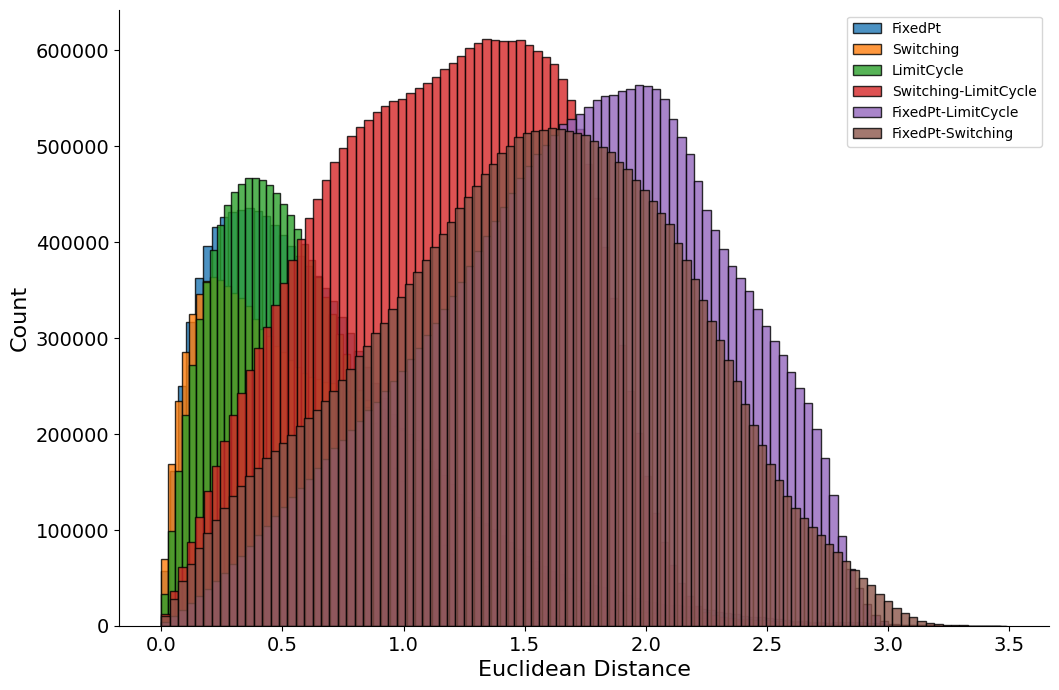

In [26]:
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(intra_class_distances[0], bins=100, alpha=0.8, label='FixedPt',  edgecolor='k')
ax.hist(intra_class_distances[1], bins=100, alpha=0.8, label='Switching', edgecolor='k')
ax.hist(intra_class_distances[2], bins=100, alpha=0.8, label='LimitCycle',  edgecolor='k')

ax.hist(inter_class_distances[3].ravel(), bins=100, alpha=0.8, label='Switching-LimitCycle',  edgecolor='k')
ax.hist(inter_class_distances[0].ravel(), bins=100, alpha=0.8, label='FixedPt-LimitCycle',  edgecolor='k')
ax.hist(inter_class_distances[1].ravel(), bins=100, alpha=0.8, label='FixedPt-Switching', edgecolor='k')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Euclidean Distance', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend()
plt.show()

ridgeline plot

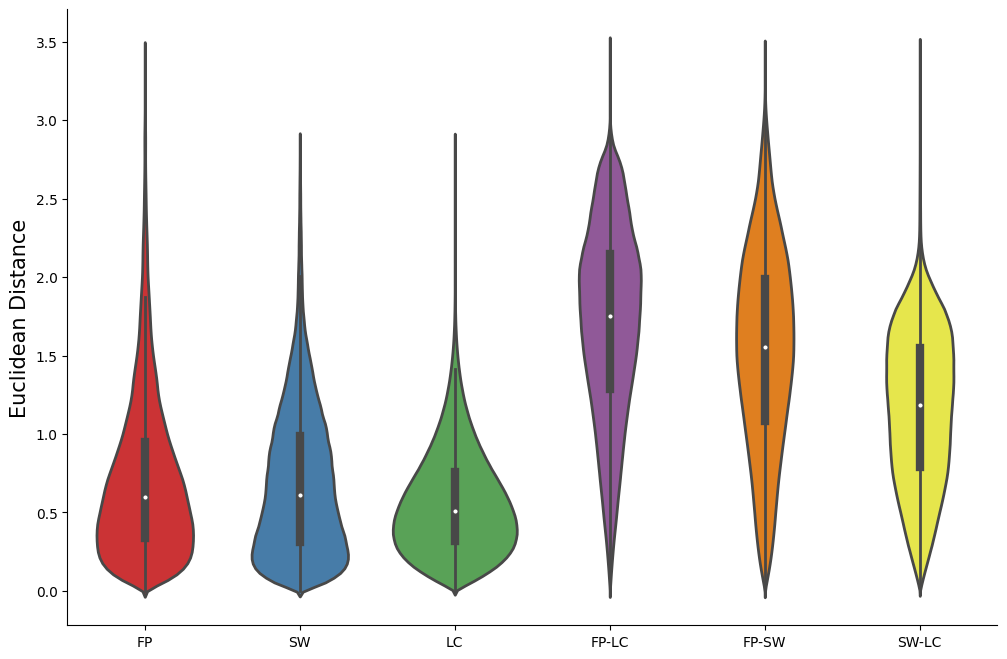

In [75]:
plt.figure(figsize=(12,8))
labels = ['FP', 'SW', 'LC', 'FP-LC', 'FP-SW', 'SW-LC']
dist_list = list([intra_class_distances[0], intra_class_distances[1], intra_class_distances[2], inter_class_distances[0].ravel(), inter_class_distances[1].ravel(), inter_class_distances[3].ravel()])
ax = sns.violinplot(data=dist_list, palette='Set1', labels=labels, linewidth=2)
plt.ylabel('Euclidean Distance', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(np.arange(6), labels)
plt.show()


Implement new version of knn, one-shot CV

In [23]:
from sklearn.neighbors import RadiusNeighborsClassifier

In [77]:
ts_val_fp, df_val_fp = sample_fixedpt(500)
ts_val_lc, df_val_lc = sample_limitCycle(500)
ts_val_sw, df_val_sw = sample_switching(500)

In [80]:
x_val = pd.concat([df_val_fp, df_val_lc, df_val_sw], ignore_index=True)
y_val = x_val['regime']

In [86]:
epsilons = np.linspace(0.03, 3, 10)
scores = list()
prob_est = list() # store probability estimates for each point
for epsilon in epsilons:
    neigh = RadiusNeighborsClassifier(radius=epsilon, outlier_label='most_frequent')
    neigh.fit(pca_train, y)
    xval = pipe.transform(x_val.iloc[:, :22])
    pca_val = pca.transform(xval)
    score = neigh.score(pca_val, y_val)
    scores.append(score)
    prob_est.append(neigh.predict_proba(pca_val))

Text(0, 0.5, 'Classification Accuracy')

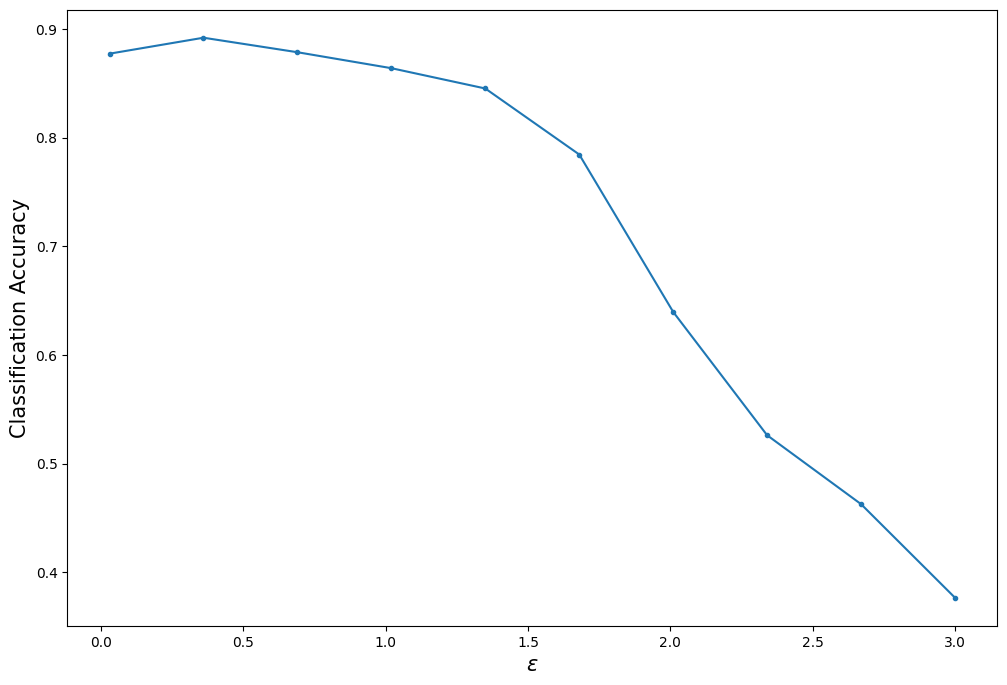

In [87]:
plt.figure(figsize=(12,8))
plt.plot(epsilons, scores, '.-')
plt.xlabel(r'$\epsilon$', fontsize=15)
plt.ylabel('Classification Accuracy', fontsize=15)

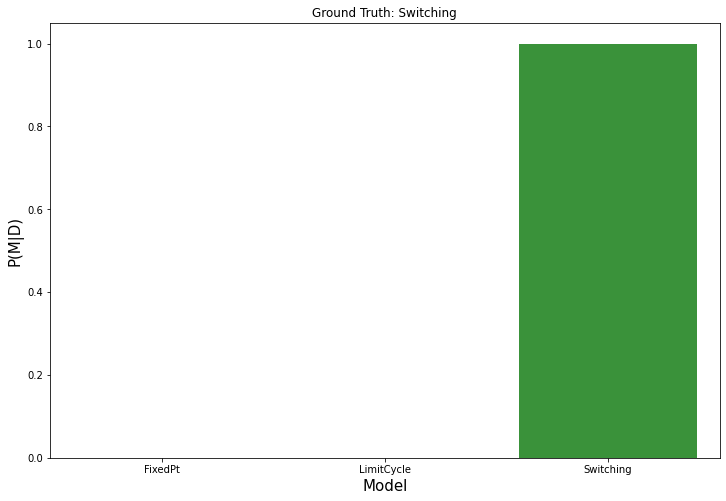

In [323]:
models = ['FixedPt', 'LimitCycle', 'Switching']
index = 1234
plt.figure(figsize=(12,8))
plt.title(f'Ground Truth: {x_val["regime"].iloc[index]}')
sns.barplot(x=models, y=prob_est[0][index])
plt.ylabel('P(M|D)', fontsize=15)
plt.xlabel('Model', fontsize=15)
plt.show()

5-fold CV using sklearn function

In [58]:
from sklearn.model_selection import StratifiedKFold

In [62]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [63]:
epsilons = np.linspace(0.03, 3, 10)
raw_scores = list() # scores across each fold for each epsilon
mean_scores = list()
std_scores = list()
for epsilon in epsilons:
    model = RadiusNeighborsClassifier(radius=epsilon, outlier_label='most_frequent')
    scores = list()
    for train_index, test_index in skf.split(x, y):
        X_train, X_test = x.iloc[train_index, :22], x.iloc[test_index, :22]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # fit and transform training data
        pipe_fit = pipe.fit(X_train.iloc[:, :22])
        X_train = pipe_fit.transform(X_train.iloc[:, :22])
        pca_fit = PCA(n_components=2).fit(X_train)
        pca_train = pca_fit.transform(X_train)

        # transform test data
        X_test = pipe_fit.transform(X_test.iloc[:, :22])
        pca_test = pca_fit.transform(X_test)

        # fit model
        model.fit(pca_train, y_train)
        score = model.score(pca_test, y_test)
        scores.append(score)
    #print(f'epsilon: {epsilon:.4f}, score: {np.mean(scores):.4f}, std: {np.std(scores):.4f}')
    raw_scores.append(scores)
    mean_scores.append(np.mean(scores, axis=0))
    std_scores.append(np.std(scores, axis=0))


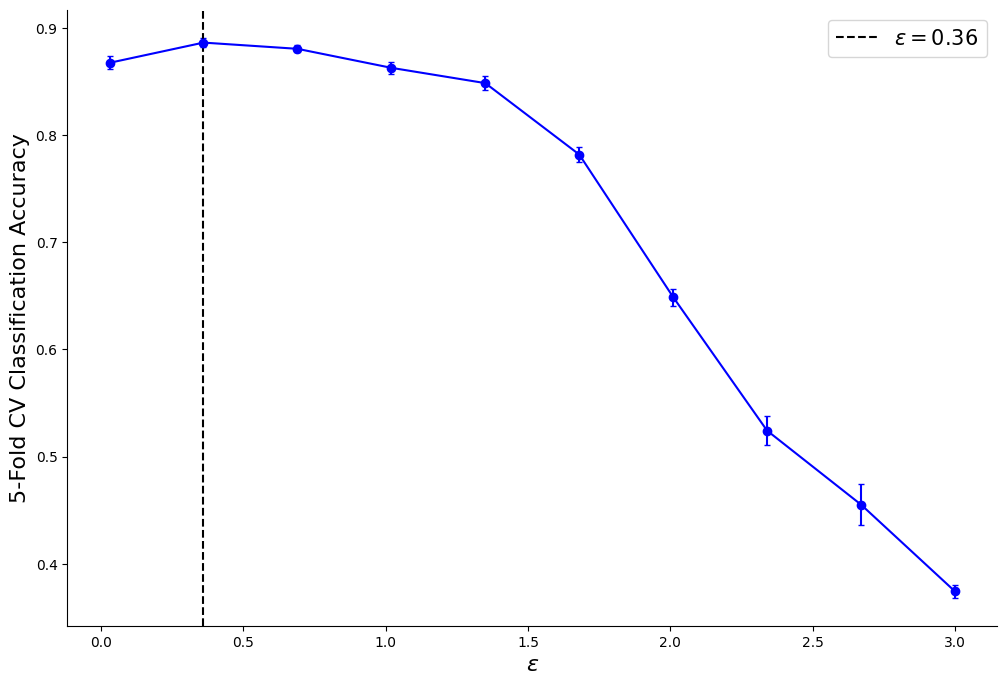

In [73]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(epsilons, mean_scores, '.-', c='b')
ax.errorbar(epsilons, mean_scores, yerr=std_scores, fmt='o', capsize=2, c='b')
plt.axvline(x=epsilons[np.argmax(mean_scores)], color='k', linestyle='--', label=f'$\epsilon = {epsilons[np.argmax(mean_scores)]}$')
plt.xlabel('$\epsilon$', fontsize=16)
plt.legend(fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('5-Fold CV Classification Accuracy', fontsize=16)
plt.show()

5-iteration evaluation. Create new functions to fix N and eta

In [968]:
def evalute_instance_space(num_train, N_val, eta_val, iter=5):
    """
    Evaluate the performance of the feature set in the instance space.
    Each iteration generates a new training and test set and evaluates the performance across a range of epsilon values.
    Default to 80/20 train/test ratio.  
    
    num_train: number of training samples to generate for each dynamical mechanism
    N: fix length of time series (should be > 200 or switching generation will take too long)
    eta: fix noise level of time series
    iter: number of iterations to average over
    """
    epsilons = np.linspace(0.03, 1.8, 20)
    iter_score = list() # scores across iteration as a function of epsilon
    num_test = int(0.25*num_train) # maintain 80/20 train/test ratio

    for i in range(iter):
        start_iter = perf_counter()
        # generate training data using random sampling as usual
        start = perf_counter()
        print(f'Generating training data for iteration {i}')
        _, df_train_sw = sample_switching(num_train)
        _, df_train_lc = sample_limitCycle(num_train)
        _, df_train_fp = sample_fixedpt(num_train)

        df_train = pd.concat([df_train_fp, df_train_sw, df_train_lc], ignore_index=True)
        end = perf_counter()
        print(f'Finished generating training data in {end-start:.2f} seconds')

        # generate switching test data using FIXED PARAMS
        start = perf_counter()
        print(f'Generating test data for iteration {i}')
        eta_val_bistable = list()
        lengths_store_bistable = list() 
        sols_list_bistable = list()
        count = 0
        while count < num_test:
            mu = np.random.uniform(low=-0.38487849, high=0.38487849)
            eta = eta_val # fixed
            N = N_val # fixed
            sol = gen_bistable(eta, mu, N)

            # calculate fixed points for given mu
            X = smp.Symbol('x', real=True)
            eq = mu + X - X**3
            roots = [j.n(6) for j in real_roots(eq, X)]
            max_root = np.max(roots)
            min_root = np.min(roots)
            max_actual = np.max(sol)
            min_actual = np.min(sol)
            # check for switching condition
            if (max_actual >= max_root) & (min_actual <= min_root):
                eta_val_bistable.append(eta)
                sols_list_bistable.append(sol)
                lengths_store_bistable.append(len(sol)) # store length of time series after burn in
                count += 1
            
        # extract features
        features_bistable = np.array([catch22.catch22_all(sols_list_bistable[i][:,0])['values'] for i in range(len(sols_list_bistable))])
        df_switching_eval = pd.DataFrame(features_bistable)
        df_switching_eval['N'] = lengths_store_bistable
        df_switching_eval['eta'] = eta_val_bistable
        df_switching_eval['regime'] = 'Switching'
        df_switching_eval['system'] = 'Bistable'
        
        # generate fixedpt test data using fixed params
        num_test_fp = int(num_test/3)
        
        eta_val_bistable = list()
        lengths_store = list()
        sols_list = list()
        count = 0
        while count < num_test_fp:
            eta = eta_val
            mu = np.random.uniform(low=-5, high=5)
            n = N_val

            sol = gen_bistable(eta, mu, n)
            X = smp.Symbol('x', real=True)
            eq = mu + X - X**3
            roots = [j.n(6) for j in real_roots(eq, X)]
            max_root = np.max(roots)
            min_root = np.min(roots)
            max_actual = np.max(sol)
            min_actual = np.min(sol)
            if (len(roots) > 1) & (max_actual >= max_root) & (min_actual <= min_root):
            # switching, do not append
                continue
            else:
                count += 1
                sols_list.append(sol)
                eta_val_bistable.append(eta)
                lengths_store.append(len(sol)) # store length of time series after burn in


        features_bistable = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
        df_bistable_fp = pd.DataFrame(features_bistable)
        df_bistable_fp['N'] = lengths_store
        df_bistable_fp['eta'] = eta_val_bistable
        df_bistable_fp['regime'] = 'FixedPoint'
        df_bistable_fp['system'] = 'Bistable'

    
        eta_val_hopf = list()
        lengths_store = list()
        sols_list = list()
        for i in range(num_test_fp):
            mu = np.random.uniform(-5, -0.01)
            eta = eta_val
            N = N_val
            sol = gen_bistable(eta, mu, N)
            lengths_store.append(len(sol)) # store length of time series after burn in
            eta_val_hopf.append(eta)
            sols_list.append(sol)

        features_hopf = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
        df_hopf_fp = pd.DataFrame(features_hopf)
        df_hopf_fp['N'] = lengths_store
        df_hopf_fp['eta'] = eta_val_hopf
        df_hopf_fp['regime'] = 'FixedPoint'
        df_hopf_fp['system'] = 'Hopf'
    
        

        eta_val_hookes = list()
        sols_list = list()
        lengths_store = list()
        for i in range(num_test_fp):
            mu = np.random.uniform(low=-5, high=-0.01)
            eta = eta_val
            N = N_val
            sol = gen_hookes(eta, mu, N)
            lengths_store.append(len(sol)) # store length of time series after burn in
            eta_val_hookes.append(eta)
            sols_list.append(sol)
        features_hookes = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
        df_hookes = pd.DataFrame(features_hookes)
        df_hookes['N'] = lengths_store
        df_hookes['eta'] = eta_val_hookes
        df_hookes['regime'] = 'FixedPoint'
        df_hookes['system'] = 'Hookes'

        df_fixedpt_eval = pd.concat([df_bistable_fp, df_hopf_fp, df_hookes], axis=0, ignore_index=True)

        # generate test data for limit cycle with fixed params
    
        eta_val_hopf = list()
        lengths_store = list()
        sols_list = list()
        for i in range(num_test):
            mu = np.random.uniform(0, 5)
            eta = eta_val
            N = N_val
            sol = gen_hopf(eta, mu, N)
            lengths_store.append(len(sol)) # store length of time series after burn in
            eta_val_hopf.append(eta)
            sols_list.append(sol)

        features_hopf = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
        df_lc_eval = pd.DataFrame(features_hopf)
        df_lc_eval['N'] = lengths_store
        df_lc_eval['eta'] = eta_val_hopf
        df_lc_eval['regime'] = 'LimitCycle'
        df_lc_eval['system'] = 'Hopf'
            
        df_test = pd.concat([df_fixedpt_eval, df_switching_eval, df_lc_eval], axis=0, ignore_index=True)

        stop = perf_counter()
        print(f'Finished Generating Test Data in {stop-start:.2f} seconds')
        print('Starting Evaluation... ')

        # rescale data 
        
        pipe_fit = pipe.fit(df_train.iloc[:,:22])
        X_train = pipe_fit.transform(df_train.iloc[:,:22])
        X_test = pipe_fit.transform(df_test.iloc[:,:22])
        
        y_train = df_train['regime']
        y_test = df_test['regime']

        # apply PCA
        pca_fit = PCA(n_components=2).fit(X_train)
        pca_train = pca_fit.transform(X_train)
        pca_test = pca_fit.transform(X_test)

        # train model and evaluate
        epsilon_score = list() # store score for each epsilon
        for epsilon in epsilons:
            model = RadiusNeighborsClassifier(radius=epsilon, outlier_label='most_frequent')
            model.fit(pca_train, y_train)
            epsilon_score.append(model.score(pca_test, y_test))
    
        # store result 
        end_iter = perf_counter()
        print(f'Finished iteration in {end_iter-start_iter:.2f} seconds, starting next iteration...')
        iter_score.append(epsilon_score)

            
    return iter_score

In [296]:
iter_score1 = evalute_instance_space(500, 500, 1.)

Generating training data for iteration 0
Finished generating training data in 319.62 seconds
Generating test data for iteration 0
Finished Generating Test Data in 23.62 seconds
Starting Evaluation... 
Finished iteration in 343.47 seconds, starting next iteration...
Generating training data for iteration 1
Finished generating training data in 313.24 seconds
Generating test data for iteration 1
Finished Generating Test Data in 23.54 seconds
Starting Evaluation... 
Finished iteration in 336.94 seconds, starting next iteration...
Generating training data for iteration 2
Finished generating training data in 330.03 seconds
Generating test data for iteration 2
Finished Generating Test Data in 24.23 seconds
Starting Evaluation... 
Finished iteration in 354.44 seconds, starting next iteration...
Generating training data for iteration 3
Finished generating training data in 319.78 seconds
Generating test data for iteration 3
Finished Generating Test Data in 24.42 seconds
Starting Evaluation... 
F

In [297]:
iter_score2 = evalute_instance_space(500, 1000, 1.)

Generating training data for iteration 0
Finished generating training data in 332.55 seconds
Generating test data for iteration 0
Finished Generating Test Data in 28.54 seconds
Starting Evaluation... 
Finished iteration in 361.29 seconds, starting next iteration...
Generating training data for iteration 1
Finished generating training data in 323.72 seconds
Generating test data for iteration 1
Finished Generating Test Data in 28.98 seconds
Starting Evaluation... 
Finished iteration in 352.87 seconds, starting next iteration...
Generating training data for iteration 2
Finished generating training data in 325.24 seconds
Generating test data for iteration 2
Finished Generating Test Data in 28.88 seconds
Starting Evaluation... 
Finished iteration in 354.34 seconds, starting next iteration...
Generating training data for iteration 3
Finished generating training data in 319.66 seconds
Generating test data for iteration 3
Finished Generating Test Data in 28.10 seconds
Starting Evaluation... 
F

In [298]:
iter_score3 = evalute_instance_space(500, 5000, 1.)

Generating training data for iteration 0
Finished generating training data in 323.53 seconds
Generating test data for iteration 0
Finished Generating Test Data in 97.48 seconds
Starting Evaluation... 
Finished iteration in 421.21 seconds, starting next iteration...
Generating training data for iteration 1
Finished generating training data in 317.02 seconds
Generating test data for iteration 1
Finished Generating Test Data in 101.30 seconds
Starting Evaluation... 
Finished iteration in 418.49 seconds, starting next iteration...
Generating training data for iteration 2
Finished generating training data in 341.39 seconds
Generating test data for iteration 2
Finished Generating Test Data in 101.39 seconds
Starting Evaluation... 
Finished iteration in 443.01 seconds, starting next iteration...
Generating training data for iteration 3
Finished generating training data in 322.94 seconds
Generating test data for iteration 3
Finished Generating Test Data in 96.04 seconds
Starting Evaluation... 

In [299]:
iter_score4 = evalute_instance_space(500, 500, 0.3)

Generating training data for iteration 0
Finished generating training data in 318.47 seconds
Generating test data for iteration 0
Finished Generating Test Data in 588.34 seconds
Starting Evaluation... 
Finished iteration in 906.96 seconds, starting next iteration...
Generating training data for iteration 1
Finished generating training data in 331.24 seconds
Generating test data for iteration 1
Finished Generating Test Data in 681.46 seconds
Starting Evaluation... 
Finished iteration in 1012.86 seconds, starting next iteration...
Generating training data for iteration 2
Finished generating training data in 337.25 seconds
Generating test data for iteration 2
Finished Generating Test Data in 585.81 seconds
Starting Evaluation... 
Finished iteration in 923.22 seconds, starting next iteration...
Generating training data for iteration 3
Finished generating training data in 334.18 seconds
Generating test data for iteration 3
Finished Generating Test Data in 700.35 seconds
Starting Evaluation.

In [300]:
iter_score5 = evalute_instance_space(500, 1000, 0.3)

Generating training data for iteration 0
Finished generating training data in 332.10 seconds
Generating test data for iteration 0
Finished Generating Test Data in 223.12 seconds
Starting Evaluation... 
Finished iteration in 555.38 seconds, starting next iteration...
Generating training data for iteration 1
Finished generating training data in 335.03 seconds
Generating test data for iteration 1
Finished Generating Test Data in 227.53 seconds
Starting Evaluation... 
Finished iteration in 562.72 seconds, starting next iteration...
Generating training data for iteration 2
Finished generating training data in 323.58 seconds
Generating test data for iteration 2
Finished Generating Test Data in 215.45 seconds
Starting Evaluation... 
Finished iteration in 539.21 seconds, starting next iteration...
Generating training data for iteration 3
Finished generating training data in 318.16 seconds
Generating test data for iteration 3
Finished Generating Test Data in 223.62 seconds
Starting Evaluation..

In [301]:
iter_score6 = evalute_instance_space(500, 5000, 0.3)

Generating training data for iteration 0
Finished generating training data in 326.47 seconds
Generating test data for iteration 0
Finished Generating Test Data in 250.39 seconds
Starting Evaluation... 
Finished iteration in 577.01 seconds, starting next iteration...
Generating training data for iteration 1
Finished generating training data in 323.37 seconds
Generating test data for iteration 1
Finished Generating Test Data in 236.62 seconds
Starting Evaluation... 
Finished iteration in 560.15 seconds, starting next iteration...
Generating training data for iteration 2
Finished generating training data in 326.42 seconds
Generating test data for iteration 2
Finished Generating Test Data in 266.91 seconds
Starting Evaluation... 
Finished iteration in 593.48 seconds, starting next iteration...
Generating training data for iteration 3
Finished generating training data in 329.43 seconds
Generating test data for iteration 3
Finished Generating Test Data in 261.07 seconds
Starting Evaluation..

Text(0, 0.5, 'Classification Accuracy')

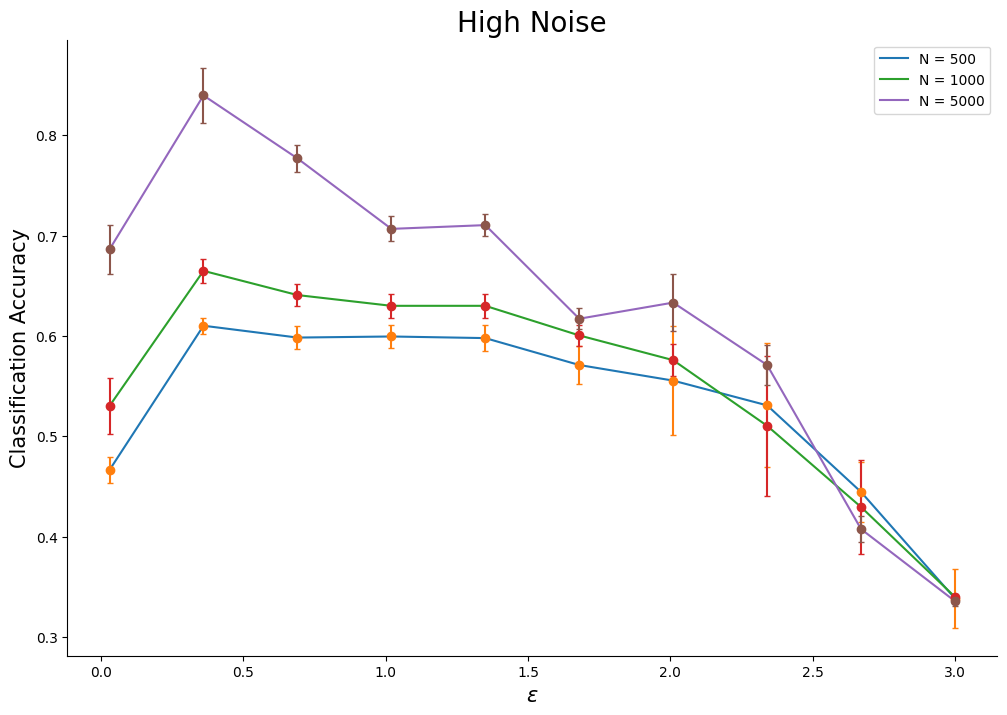

In [173]:
fig, ax = plt.subplots(figsize=(12,8))
plt.title('High Noise', fontsize=20)
ax.plot(epsilons, np.mean(iter_score1, axis=0), label='N = 500')
ax.errorbar(epsilons, np.mean(iter_score1, axis=0), yerr=np.std(iter_score1, axis=0), fmt='o', capsize=2)
ax.plot(epsilons, np.mean(iter_score2, axis=0), label='N = 1000')
ax.errorbar(epsilons, np.mean(iter_score2, axis=0), yerr=np.std(iter_score2, axis=0), fmt='o', capsize=2)
ax.plot(epsilons, np.mean(iter_score3, axis=0), label='N = 5000')
ax.errorbar(epsilons, np.mean(iter_score3, axis=0), yerr=np.std(iter_score3, axis=0), fmt='o', capsize=2)

plt.legend()
plt.xlabel('$\epsilon$', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Classification Accuracy (%)', fontsize=15)

Text(0, 0.5, 'Classification Accuracy')

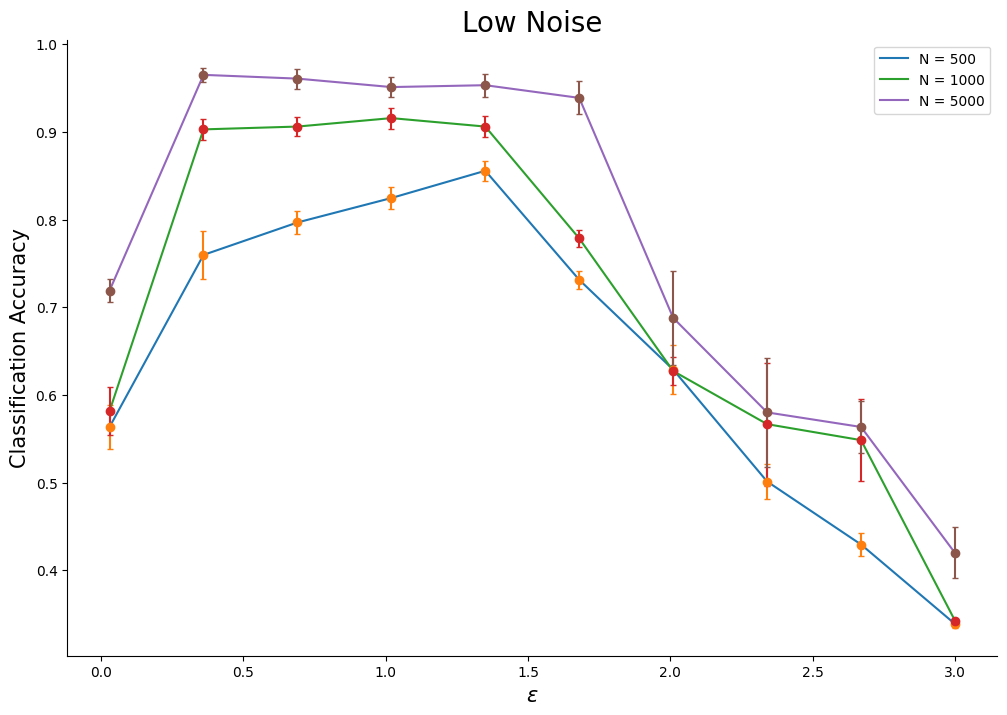

In [174]:
fig, ax = plt.subplots(figsize=(12,8))
plt.title('Low Noise', fontsize=20)
ax.plot(epsilons, np.mean(iter_score4, axis=0), label='N = 500')
ax.errorbar(epsilons, np.mean(iter_score4, axis=0), yerr=np.std(iter_score4, axis=0), fmt='o', capsize=2)
ax.plot(epsilons, np.mean(iter_score5, axis=0), label='N = 1000')
ax.errorbar(epsilons, np.mean(iter_score5, axis=0), yerr=np.std(iter_score5, axis=0), fmt='o', capsize=2)

ax.plot(epsilons, np.mean(iter_score6, axis=0), label='N = 5000')
ax.errorbar(epsilons, np.mean(iter_score6, axis=0), yerr=np.std(iter_score6, axis=0), fmt='o', capsize=2)
plt.legend()
plt.xlabel('$\epsilon$', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Classification Accuracy (%)', fontsize=15)

Perform instance subset selection using hierarchical clustering to cluster instances based on their feature vector values. Instances which are more similar (in terms of feature vector values) are clustered together. The number of clusters is set to be the number of instances to retain (such that one instance is retained from each cluster). For clusters with more than one instance, the instance which minimises the sum of pairwise distances to other instances in the cluster is selected as the most representative. 

# Optimisation

Reweighting features based on log-loss objective function

<AxesSubplot: xlabel='PC1', ylabel='PC2'>

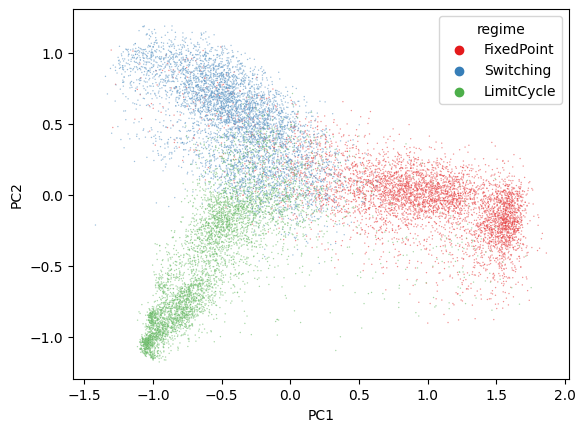

In [19]:
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='regime', palette='Set1', s=1, alpha=0.5)

In [20]:
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder

In [934]:
X = xhat
y = x['regime']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [39]:
knn = RadiusNeighborsClassifier(radius=0.76, outlier_label='most_frequent')
knn.fit(X_train, y_train)

RadiusNeighborsClassifier(outlier_label='most_frequent', radius=0.76)

In [40]:
y_pred = knn.predict_proba(X_test)
log_loss_value = log_loss(y_test, y_pred)
log_loss_value

0.39291631570240376

Plot log-loss versus epsilon as opposed to classifier accuracy. Also compute in 22-dim feature space as opposed to the 2-dim space as the previous evaluations were doing. 

In [30]:
radii = np.linspace(0.01, 5, 1000)
scores = list()
for radius in radii:
    knn = RadiusNeighborsClassifier(radius=radius, outlier_label='most_frequent')
    knn.fit(X_train, y_train)
    y_pred = knn.predict_proba(X_test)
    log_loss_value = log_loss(y_test, y_pred)
    scores.append(log_loss_value)

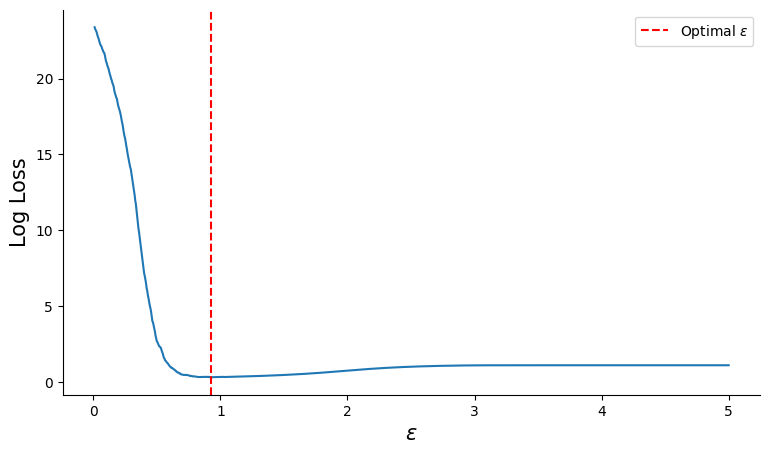

In [41]:
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(radii, scores)
ax.set_xlabel('$\epsilon$', fontsize=15)
ax.set_ylabel('Log Loss', fontsize=15)
ax.axvline(x=radii[np.argmin(scores)], color='r', linestyle='--', label='Optimal $\epsilon$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
plt.show()

In [42]:
print('Optimal epsilon: ', radii[np.argmin(scores)])
knn_optimal = RadiusNeighborsClassifier(radius=radii[np.argmin(scores)], outlier_label='most_frequent')
knn_optimal.fit(X_train, y_train)
print(f'Accuracy at optimal epsilon: {knn_optimal.score(X_test, y_test)}')

Optimal epsilon:  0.9240840840840842
Accuracy at optimal epsilon: 0.8876666666666667


Optimise feature weightings such that the log-loss is minimised.

Custom distance metric generation

Generate data

In [935]:
ts1_opt, df1_opt = sample_fixedpt(1000)
ts2_opt, df2_opt = sample_switching(1000)
ts3_opt, df3_opt = sample_limitCycle(1000)

In [936]:
data_opt = pd.concat([df1_opt, df2_opt, df3_opt], ignore_index=True)
pipe_fit = pipe.fit(data_opt.iloc[:,:22])
xhat_opt = pipe_fit.transform(data_opt.iloc[:,:22])

In [937]:
X_train, X_test, y_train, y_test = train_test_split(xhat_opt, data_opt['regime'], test_size=0.2, random_state=0)

# Un-Optimised Space

Obtain log-loss and accuracy for un-optimised space

In [989]:
radii = np.linspace(0.01, 4, 50)
scores = list()
log_loss_vals = list()
for radius in radii:
    knn = RadiusNeighborsClassifier(radius=radius, outlier_label='most_frequent')
    knn.fit(X_train, y_train)
    y_pred = knn.predict_proba(X_test)
    log_loss_value = log_loss(y_test, y_pred)
    scores.append(knn.score(X_test, y_test))
    log_loss_vals.append(log_loss_value)

Text(0.5, 1.0, 'Unoptimised Feature Space, Min Log Loss = 0.440')

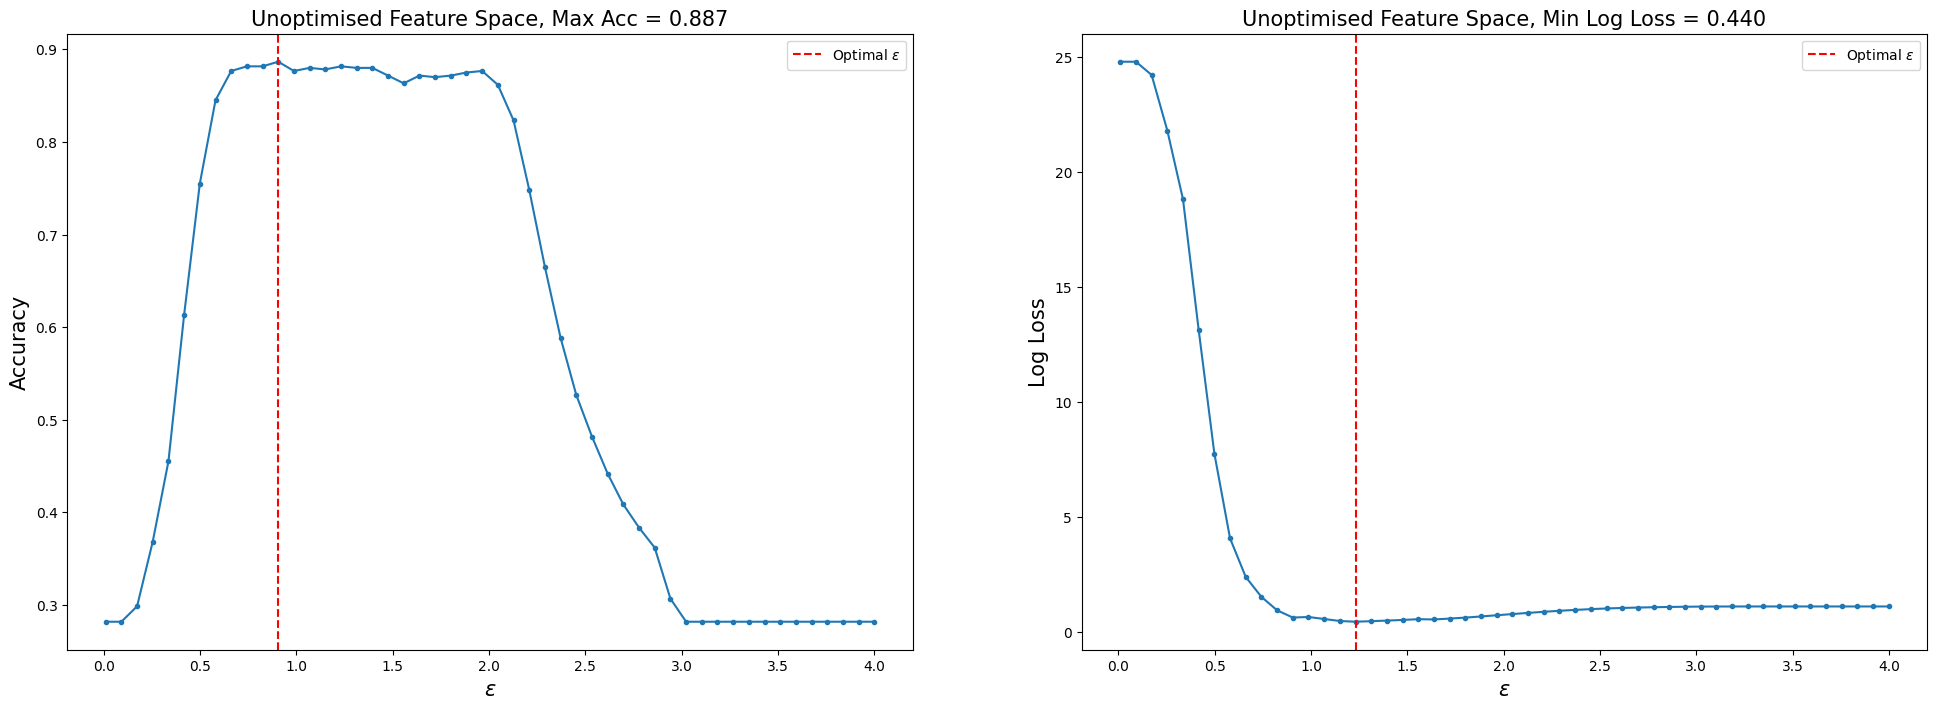

In [991]:
fig, ax = plt.subplots(1, 2, figsize=(24,8))
ax[0].plot(radii, scores, '.-')
ax[0].set_xlabel('$\epsilon$', fontsize=15)
ax[0].set_ylabel('Accuracy', fontsize=15)
ax[0].axvline(x=radii[np.argmax(scores)], color='r', linestyle='--', label='Optimal $\epsilon$')
ax[0].legend()
ax[0].set_title(f'Unoptimised Feature Space, Max Acc = {np.max(scores):.3f}', fontsize=15)

ax[1].plot(radii, log_loss_vals, '.-')
ax[1].set_xlabel('$\epsilon$', fontsize=15)
ax[1].set_ylabel('Log Loss', fontsize=15)
ax[1].axvline(x=radii[np.argmin(log_loss_vals)], color='r', linestyle='--', label='Optimal $\epsilon$')
ax[1].legend()
ax[1].set_title(f'Unoptimised Feature Space, Min Log Loss = {np.min(log_loss_vals):.3f}', fontsize=15)


Text(0, 0.5, 'PC2')

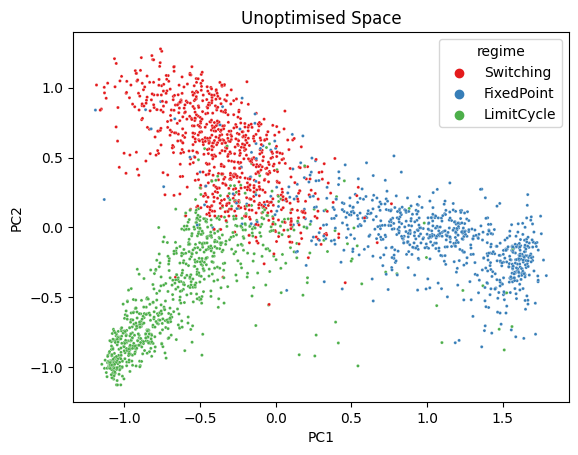

In [941]:
pca_before = PCA(n_components=2).fit_transform(X_train)
sns.scatterplot(x=pca_before[:,0], y=pca_before[:,1], hue=y_train, palette='Set1', s=5)
plt.title('Unoptimised Space')
plt.xlabel('PC1')
plt.ylabel('PC2')

create objective function to maximise interclass distances and minimise intraclass distances by minimising a ratio of the two

In [836]:
def obj_maximally_distinguish(weights, X_train, y_train):
    """Returns ratio of inter-class distance to intra-class distance"""

    # define distance metric
    dist = DistanceMetric.get_metric('minkowski', p=2, w=weights)
    classes = np.unique(y_train)
    # calculate mean within class distance
    within_class_dist = list()
    for c in classes:
        X_class = X_train[y_train == c]
        within_class_dist.append(np.mean(dist.pairwise(X_class)))
    # calculate mean between class distance
    between_class_dist = list()
    between_class_dist.append(np.mean(dist.pairwise(X_train[y_train == classes[0]], X_train[y_train == classes[1]])))
    between_class_dist.append(np.mean(dist.pairwise(X_train[y_train == classes[0]], X_train[y_train == classes[2]])))
    between_class_dist.append(np.mean(dist.pairwise(X_train[y_train == classes[1]], X_train[y_train == classes[2]])))

    return np.mean(within_class_dist)/np.mean(between_class_dist)

Deep metric learning. Idea is to learn a custom distance metric which minimises the intra-class distance and maximises the inter-class distance. The custom distance metric is then fed into the knn classifier to compute distances.

In [1016]:
from metric_learn import MMC_Supervised
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from umap import UMAP

In [942]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [943]:
mmc = MMC_Supervised(random_state=245)
mmc_fit = mmc.fit(X_train, y_train_encoded)
X_mmc = mmc_fit.transform(X_train)

Text(0, 0.5, 'UMAP-2')

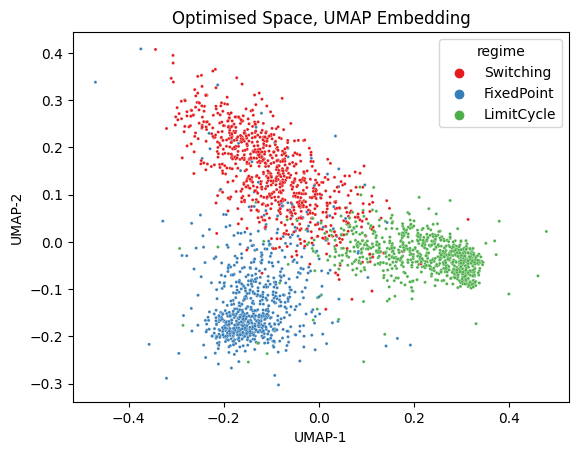

In [1024]:
#pca_mmc = PCA(n_components=2).fit_transform(X_mmc)
mds_mmc = MDS(n_components=2, random_state=42).fit_transform(X_mmc)
#tsne_mmc = TSNE(n_components=2, verbose=0, perplexity=20, random_state=42).fit_transform(X_mmc)
#umap_mmc = UMAP(n_components=2, random_state=42, n_neighbors=300).fit_transform(X_mmc)
sns.scatterplot(x=mds_mmc[:,0], y=mds_mmc[:,1], hue=y_train, palette='Set1', s=5)
plt.title('Optimised Space, UMAP Embedding')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')

In [981]:
learned_metric = mmc.get_metric()

In [982]:
radii = np.linspace(0.001, 1, 100)
log_loss_values = list()
scores = list()
for radius in radii:
    rnc_optimised = RadiusNeighborsClassifier(radius=radius, outlier_label='most_frequent', metric=learned_metric)
    rnc_optimised.fit(X_train, y_train_encoded)
    y_pred = rnc_optimised.predict_proba(X_test)
    log_loss_value = log_loss(y_test, y_pred)
    score = rnc_optimised.score(X_test, y_test_encoded)
    log_loss_values.append(log_loss_value)
    scores.append(score)

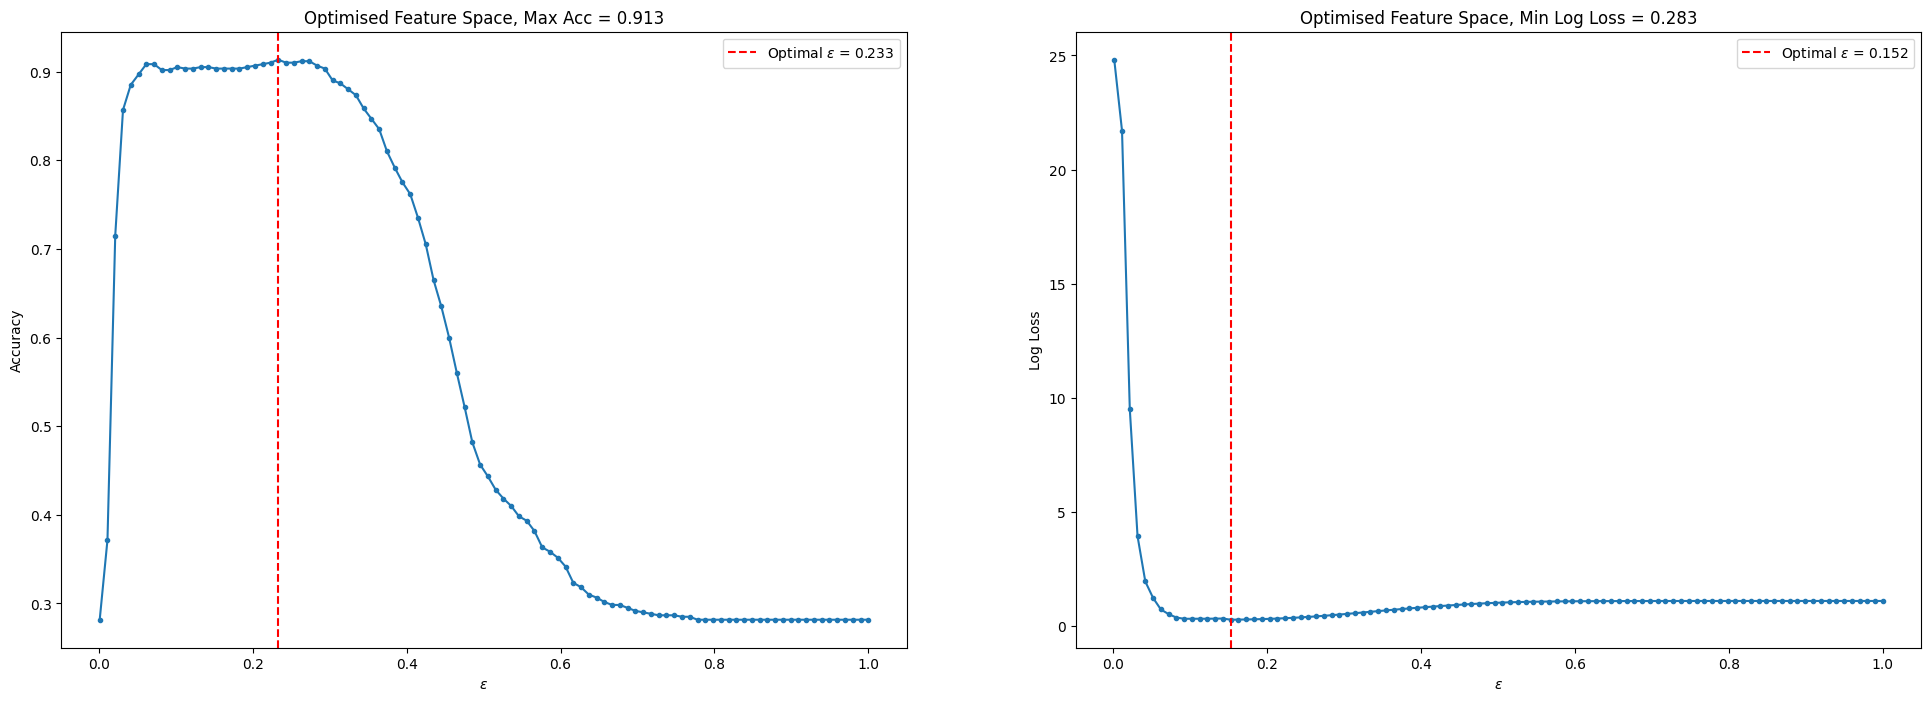

In [988]:
fig, ax = plt.subplots(1, 2, figsize=(24,8))
ax[0].plot(radii, scores, '.-')
ax[0].set_xlabel('$\epsilon$')
ax[0].set_ylabel('Accuracy')
ax[0].set_title(f'Optimised Feature Space, Max Acc = {np.max(scores):.3f}')
ax[0].axvline(x=radii[np.argmax(scores)], color='r', linestyle='--', label=f'Optimal $\epsilon$ = {np.round(radii[np.argmax(scores)], 3)}')
ax[0].legend()

ax[1].plot(radii, log_loss_values, '.-')
ax[1].set_xlabel('$\epsilon$')
ax[1].set_ylabel('Log Loss')
ax[1].set_title(f'Optimised Feature Space, Min Log Loss = {np.min(log_loss_values):.3f}')
ax[1].axvline(x=radii[np.argmin(log_loss_values)], color='r', linestyle='--', label=f'Optimal $\epsilon$ = {np.round(radii[np.argmin(log_loss_values)], 3)}')
ax[1].legend()


Now scale up to full 15000 instance space

In [1029]:
X = xhat
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [1034]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

Text(0.5, 1.0, 'Unoptimised Space')

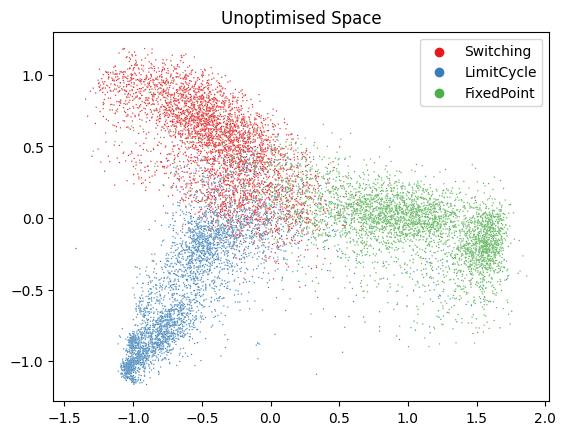

In [1067]:
pca_unoptimized = PCA(n_components=2).fit_transform(X_train)
sns.scatterplot(x=pca_unoptimized[:,0], y=pca_unoptimized[:,1], hue=le.inverse_transform(y_train), palette='Set1', s=1)
plt.title('Unoptimised Space')

Compute accuracy/log-loss curves for unoptimised space

In [1039]:
radii = np.linspace(0.01, 2, 100)
log_loss_vals_unopt = list()
scores_unopt = list()
for radius in radii:
    rnc = RadiusNeighborsClassifier(radius=radius, outlier_label='most_frequent')
    rnc.fit(X_train, y_train)
    y_pred = rnc.predict_proba(X_test)
    log_loss_val = log_loss(y_test, y_pred)
    score = rnc.score(X_test, y_test)
    log_loss_vals_unopt.append(log_loss_val)
    scores_unopt.append(score)

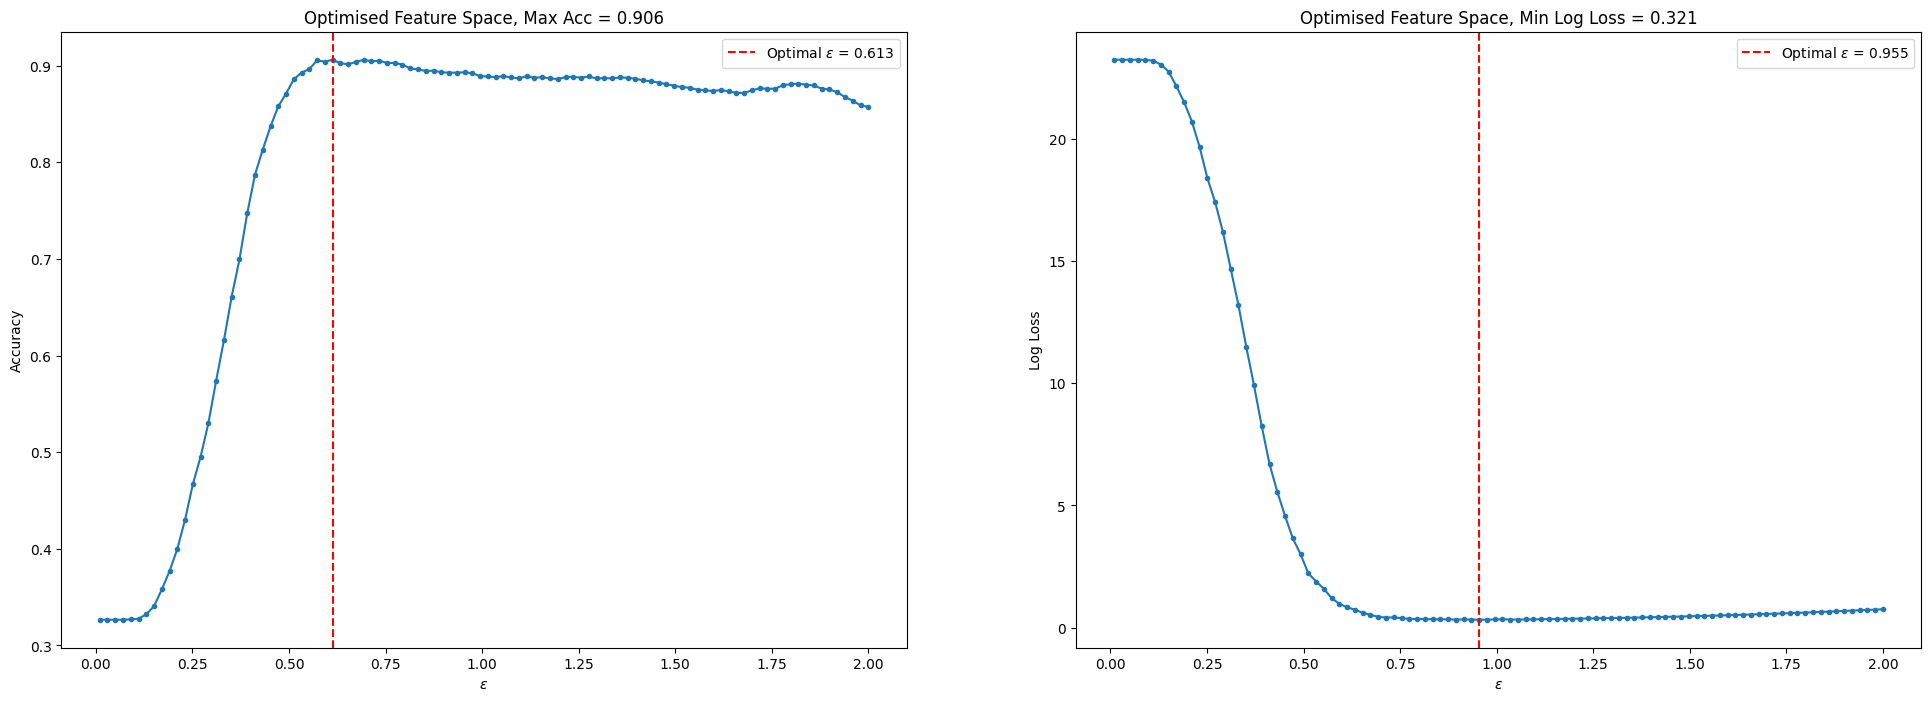

In [1051]:
radii = np.linspace(0.01, 2, 100)
fig, ax = plt.subplots(1, 2, figsize=(24,8))
ax[0].plot(radii, scores_unopt, '.-')
ax[0].set_xlabel('$\epsilon$')
ax[0].set_ylabel('Accuracy')
ax[0].set_title(f'Optimised Feature Space, Max Acc = {np.max(scores_unopt):.3f}')
ax[0].axvline(x=radii[np.argmax(scores_unopt)], color='r', linestyle='--', label=f'Optimal $\epsilon$ = {np.round(radii[np.argmax(scores_unopt)], 3)}')
ax[0].legend()

ax[1].plot(radii, log_loss_vals_unopt, '.-')
ax[1].set_xlabel('$\epsilon$')
ax[1].set_ylabel('Log Loss')
ax[1].set_title(f'Optimised Feature Space, Min Log Loss = {np.min(log_loss_vals_unopt):.3f}')
ax[1].axvline(x=radii[np.argmin(log_loss_vals_unopt)], color='r', linestyle='--', label=f'Optimal $\epsilon$ = {np.round(radii[np.argmin(log_loss_vals_unopt)], 3)}')
ax[1].legend()

Now do the same, but for the optimised space

In [1043]:
mmc = MMC_Supervised(random_state=245)
mmc_fit = mmc.fit(X_train, y_train)
X_mmc = mmc_fit.transform(X_train)
learned_metric = mmc.get_metric()

Text(0.5, 1.0, 'Optimised Space, PCA')

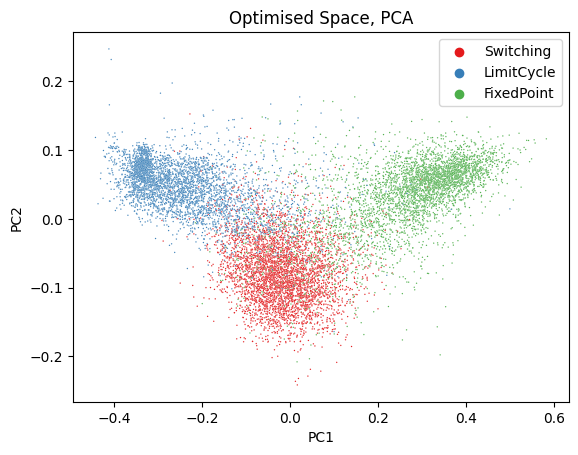

In [1069]:
pca_mmc = PCA(n_components=2).fit_transform(X_mmc)
#tsne_mmc = TSNE(n_components=2, verbose=0, perplexity=20, random_state=42).fit_transform(X_mmc)
sns.scatterplot(x=pca_mmc[:,0], y=pca_mmc[:,1], hue=le.inverse_transform(y_train), palette='Set1', s=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Optimised Space, PCA')

In [1057]:
radii = np.linspace(0.01, 0.2, 10)
log_loss_values_opt = list()
scores_opt = list()
for radius in radii:
    print(radius)
    rnc_optimised = RadiusNeighborsClassifier(radius=radius, outlier_label='most_frequent', metric=learned_metric)
    rnc_optimised.fit(X_train, y_train)
    y_pred = rnc_optimised.predict_proba(X_test)
    log_loss_value = log_loss(y_test, y_pred)
    score = rnc_optimised.score(X_test, y_test)
    log_loss_values_opt.append(log_loss_value)
    scores_opt.append(score)

0.01
0.03111111111111111
0.052222222222222225
0.07333333333333333
0.09444444444444444
0.11555555555555555
0.1366666666666667
0.1577777777777778
0.1788888888888889
0.2


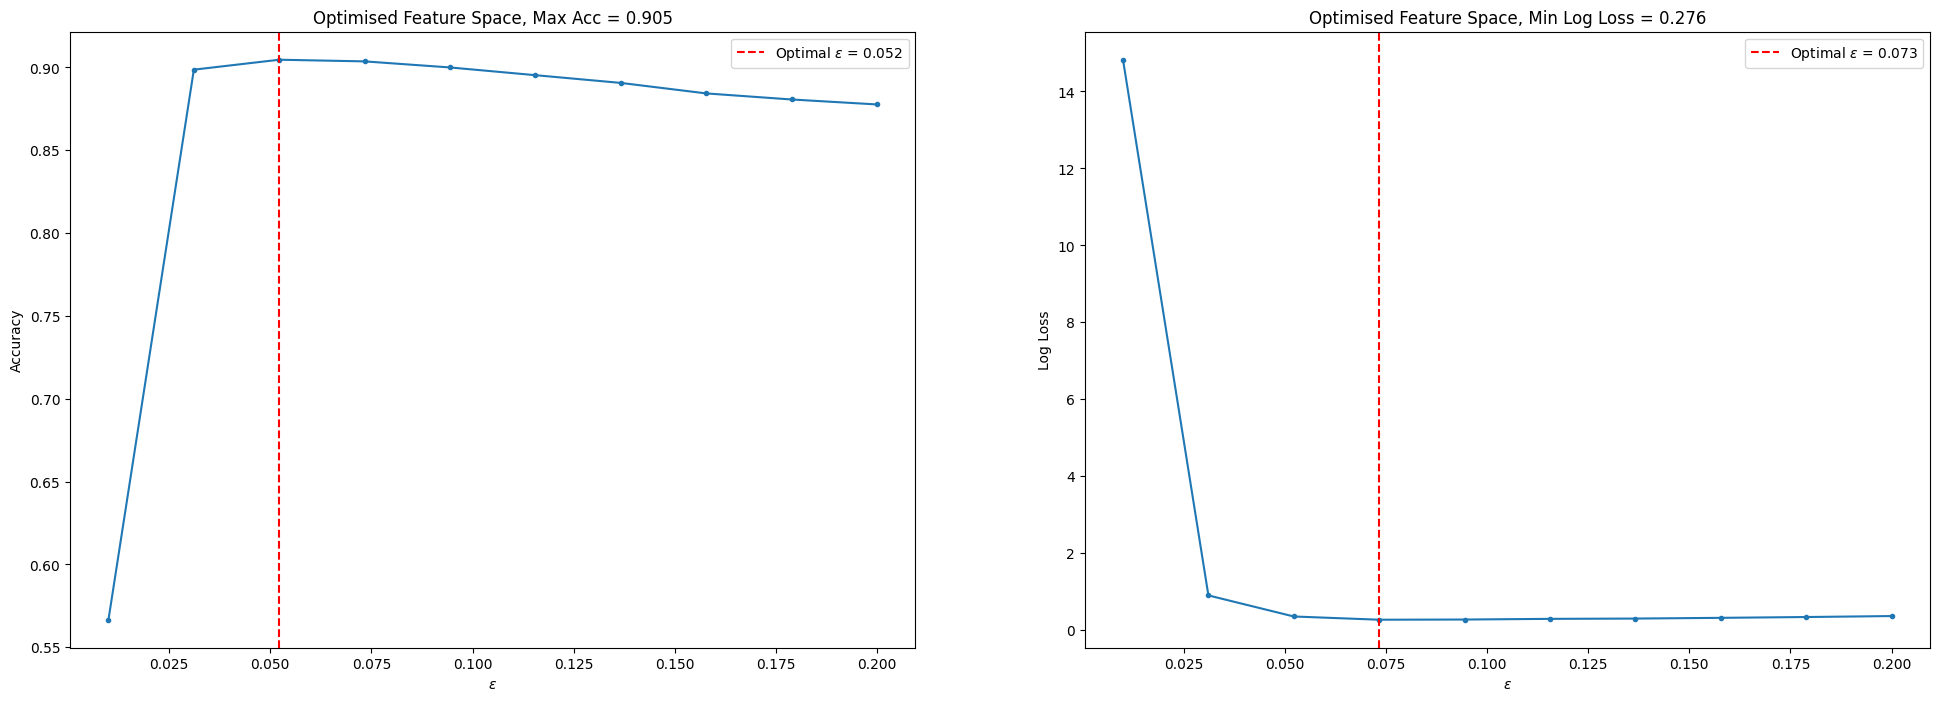

In [1058]:
radii = np.linspace(0.01, 0.2, 10)
fig, ax = plt.subplots(1, 2, figsize=(24,8))
ax[0].plot(radii, scores_opt, '.-')
ax[0].set_xlabel('$\epsilon$')
ax[0].set_ylabel('Accuracy')
ax[0].set_title(f'Optimised Feature Space, Max Acc = {np.max(scores_opt):.3f}')
ax[0].axvline(x=radii[np.argmax(scores_opt)], color='r', linestyle='--', label=f'Optimal $\epsilon$ = {np.round(radii[np.argmax(scores_opt)], 3)}')
ax[0].legend()

ax[1].plot(radii, log_loss_values_opt, '.-')
ax[1].set_xlabel('$\epsilon$')
ax[1].set_ylabel('Log Loss')
ax[1].set_title(f'Optimised Feature Space, Min Log Loss = {np.min(log_loss_values_opt):.3f}')
ax[1].axvline(x=radii[np.argmin(log_loss_values_opt)], color='r', linestyle='--', label=f'Optimal $\epsilon$ = {np.round(radii[np.argmin(log_loss_values_opt)], 3)}')
ax[1].legend()


## SkTime Comparison